c:\Users\pavle\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


tensor([0.6247], grad_fn=<PowBackward0>)
tensor([0.0150], grad_fn=<PowBackward0>)
tensor([0.0015], grad_fn=<PowBackward0>)
tensor([0.0002], grad_fn=<PowBackward0>)
tensor([1.6062e-05], grad_fn=<PowBackward0>)
tensor([1.7626e-06], grad_fn=<PowBackward0>)
tensor([1.9350e-07], grad_fn=<PowBackward0>)
tensor([2.1013e-08], grad_fn=<PowBackward0>)
tensor([2.3080e-09], grad_fn=<PowBackward0>)
tensor([2.5708e-10], grad_fn=<PowBackward0>)


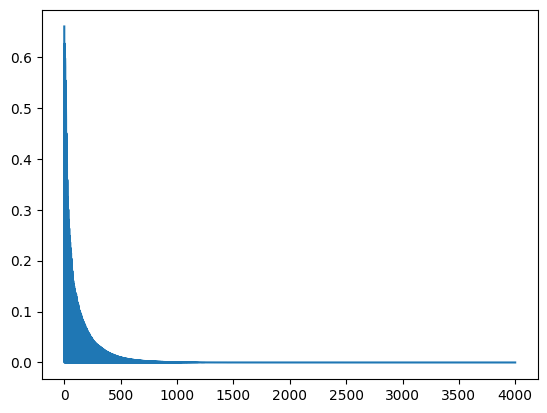

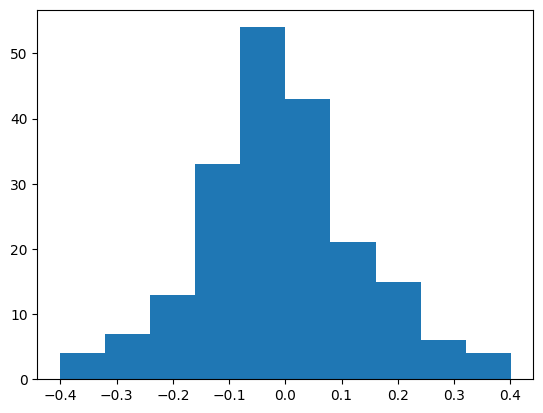

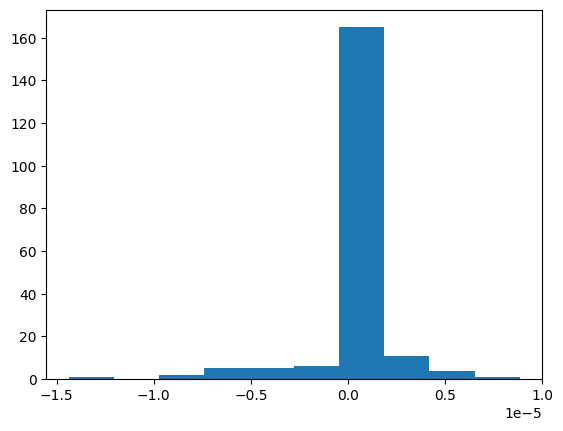

In [2]:
import torch
import numpy as np
np.random.seed(100)

x = np.random.randn(2, 100) * 0.1
y = np.random.randn(100, 1)

x = x.astype(np.float32)
y = y.astype(np.float32)

class xor_net_torch():

    def __init__(self):
        self.L1 = torch.Tensor(x)        ; self.L1.requires_grad = True 
        self.L2 = torch.Tensor(y)        ; self.L1.requires_grad = True
        
    def forward(self, x):
        o = torch.nn.ReLU()
        fir = o(x.matmul(self.L1))
        out = fir.matmul(self.L2) * 0.3
        return out

xor_torch = xor_net_torch()
optim = torch.optim.SGD((xor_torch.L1, xor_torch.L2),lr = 0.001, momentum = 0.9)


X_data_torch = torch.Tensor([[1.,0.], [1., 1.], [0., 0.], [0.,1.]])
Y_data_torch= torch.Tensor([[1.], [0.], [0.], [1.]])
loss_ = []
empty_numpy  = np.array([])
empty_numpy2  = np.array([])

for i in range(1000):
    for x, y in zip(X_data_torch ,Y_data_torch):
        
        

        logits = xor_torch.forward(x)
        
        loss = ((y - logits)**2)
        
        optim.zero_grad()

        loss_.append(loss)

        loss.backward()
        
        optim.step()

        p = np.append(empty_numpy, xor_torch.L1.detach().numpy().flatten())
        o =  np.append(empty_numpy2, xor_torch.L1.grad.detach().numpy().flatten())
        
       

    if i % 100 == 0:
        print(loss)

import matplotlib.pyplot as plt
loss_plot  = [x.detach().numpy() for x in loss_]
plt.plot(loss_plot)
plt.show()

plt.hist(p)
plt.show()

plt.hist(o)
plt.show()

In [3]:
import numpy as np
import TensorOps
np.set_printoptions(precision = 5)  # this is ugly here

class Tensor():

    def __init__(self, data, _children = () , label = ""):
        self.ALL_PARAMS = []
        self.label = label
        self.data = data if isinstance(data, (np.ndarray, np.generic)) else np.array(data, dtype = np.float32)
        self.shape = self.data.shape
        self._backward = lambda : None
        self.prev = set(_children)
        self.grad = 0.0

    def __repr__(self):
        return f"<Tensor = {self.data}>"

    def size(self)-> int: return self.data.size

    def  __getitem__(self, index):
        return Tensor(self.data[index])

    def __add__(self, other)-> 'Tensor':

        other = other if isinstance(other, Tensor) else Tensor(other)
        output_T = Tensor(np.add(self.data, other.data), (self, other))
        

        def _backward():      
            self.grad  += Tensor(output_T.grad.data)
            other.grad += Tensor(output_T.grad.data)

        output_T._backward = _backward
        return output_T

    def __mul__(self, other)-> 'Tensor': 
        other = other if isinstance(other, Tensor) else Tensor(other)
        output_T = Tensor(np.multiply(self.data, other.data), (self, other))

        def _backward():
            self.grad += Tensor(np.multiply(other.data,output_T.grad.data))
            other.grad += Tensor(np.multiply(self.data, output_T.grad.data))

        output_T._backward = _backward
        return output_T
    
    def __pow__(self, other) -> 'Tensor':                                       #https://testbook.com/learn/maths-derivative-of-exponential-function
        other = other if isinstance(other, Tensor) else Tensor(other)
        output_T = Tensor(np.power(self.data, other.data), (self,))

        def _backward():
            self.grad += Tensor(other.data * (np.power(self.data, (other.data - 1))) *output_T.grad.data)
            #other.grad += Tensor(np.log(self.data + 1e-8) * output_T.grad.data * output_T.data)

        output_T._backward = _backward
        return output_T

    def __sub__(self, other)-> 'Tensor':
        other  = other if isinstance(other , Tensor) else Tensor(other)
        output_T = Tensor(self.data - other.data, (self, other))

        def _backward():
            self.grad += Tensor(output_T.grad.data)
            other.grad += Tensor(output_T.grad.data * -1)

        output_T._backward = _backward
        return output_T 
    
    def __radd__(self, other) -> 'Tensor': return self + other
    def __rmul__(self, other)-> 'Tensor': return self * other
    def __rsub__(self, other)-> 'Tensor': return other + (self * -1)
    def __truediv__(self, other)-> 'Tensor': return self * (other **-1)
    def __rtruediv__(self, other)-> 'Tensor': return other * (self**-1)
    def __neg__(self)-> 'Tensor':  return self * -1                            # TODO this may couse errors

    #-                                             UNARY      math                                     -
    def sum(self) -> 'Tensor':
        output_T = Tensor(np.sum(self.data), (self, ))
  
        def _backward():
            self.grad += Tensor(np.ones_like(self.data) * output_T.grad.data)

        output_T._backward = _backward
        return output_T
    
    def log(self)-> 'Tensor':
        output_T = Tensor(np.log(self.data + 1e-8) (self,))

        def _backward():
            self.grad +=  Tensor((1 / output_T.data) * output_T.grad.data)
        
        output_T._backward = _backward
        return output_T
    
    def mean(self)-> 'Tensor':
        output_T = Tensor(np.mean(self.data), (self,))

        def _backward():
            self.grad += Tensor(np.ones_like(self.data) / self.data.size * output_T.grad.data)

        output_T._backward = _backward
        return output_T
    
    def sqrt(self)-> 'Tensor':
        output_T = Tensor(np.sqrt(self.data), (self, ))

        def _backward():
            self.grad  += Tensor( 0.5 * self.data * output_T.grad.data)

        output_T._backward = _backward
        return output_T
    #                                            UNARY transformation                                          -
    def abs(self) -> 'Tensor':   
        output_T =  Tensor(np.abs(self.data) , (self,))
        def _backward():
            self.grad  = Tensor(np.sign(self.data) * output_T.grad.data)

        output_T._backward = _backward
        return output_T 
                 
    def T(self) -> 'Tensor':                                                  
        output_T = Tensor(np.transpose(self.data), (self, ))
        def _backward():
            self.grad = Tensor(np.transpose(np.inner(output_T.grad.data, np.ones_like(self.data))))                                   #TODO find a nicer way to do this

        output_T._backward  = _backward
        return output_T
    
    def unsqueeze(self, axis) -> 'Tensor':
        return Tensor(np.expand_dims(self.data, axis = axis))
    #                                                DOT                                                     - 
    def dot(self, other) -> 'Tensor':
        other = other if isinstance(other , Tensor) else Tensor(other)
        output_T  = Tensor(self.data.dot(other.data), (self, other))
        
        def _backward():
            if np.ndim(self.data) < 2 :
                self.data = np.reshape(self.data, (1, self.data.shape[0])) 
        
            if np.ndim(output_T.grad.data) < 2:
                output_T.grad.data = np.reshape(output_T.grad.data, (output_T.grad.data.shape[-1], 1)) ##THIS ONE
            
            self.grad += output_T.grad.data.dot(np.transpose(other.data))  # 1x3 * 3x1
            other.grad += np.transpose(self.data).dot(output_T.grad.data)  # 3x1 1x1 


            
            self.grad = Tensor(np.reshape(self.grad, (self.data.shape)))
            other.grad = Tensor(np.reshape(other.grad.data, (other.shape)))
    
            assert self.grad.shape == self.data.shape
            assert other.grad.shape == other.shape  

        output_T._backward = _backward
        return output_T
    #                                               Activation functions                                      - 
    def ReLU(self) -> 'Tensor':
        output_T = Tensor(np.maximum(0, self.data), (self, ))

        def _backward():
            self.grad += Tensor((output_T.data > 0) * output_T.grad.data)

        output_T._backward = _backward
        return output_T
    
    def Sigmoid(self) -> 'Tensor':
        output_T = Tensor(1/(1 + np.exp(-self.data)), (self, ))

        def _backwrad():
            self.grad += Tensor((output_T.data - output_T.data**2) * output_T.grad.data)

        output_T._backward = _backwrad
        return output_T
    
    def Tanh(self) -> 'Tensor':
        output_T =Tensor(np.tanh(self.data), (self,))

        def _backward():
            self.grad += Tensor((1- output_T.data**2) * output_T.grad.data)
        
        output_T._backward = _backward
        return output_T
    
    def Softmax(self, axis = None) -> 'Tensor' :                             # https://stackoverflow.com/questions/42599498/numerically-stable-softmax https://math.stackexchange.com/questions/2843505/derivative-of-softmax-without-cross-entropy
        output_T = Tensor(TensorOps.SOFTMAX.forward(self, axis = axis), (self, ))

        def _backward():                                       
            self.grad = TensorOps.SOFTMAX.backward(self, output_T.grad)   # FIX THIS

        output_T._backward = _backward
        return output_T
    
    # TODO maybe add logsoftmax

    @classmethod
    def zeros(cls, shape)-> 'Tensor': return cls(np.zeros(shape))
        
    @classmethod
    def ones(cls, shape)-> 'Tensor': return cls(np.ones(shape))

    @classmethod
    def ones_like(cls, Tensor)-> 'Tensor' : return cls(np.ones(Tensor.shape))
       
    @classmethod
    def zeros_like(cls, Tensor)-> 'Tensor': return cls(np.zeros(Tensor.shape))

    RNG = np.random.default_rng() #https://numpy.org/doc/stable/reference/random/generator.html
    @classmethod
    def randn(cls, shape)-> 'Tensor': return cls(Tensor.RNG.standard_normal( size = shape))
        
    @classmethod
    def uniform(cls, shape)-> 'Tensor': return cls(Tensor.RNG.uniform(low = 0 , high =  1, size = shape))
       
    @classmethod
    def arange(cls, start, stop, step)-> 'Tensor': return cls(np.arange(start = start, stop = stop , step = step ))

    #-                                           ENGINE                                                  -
    def backward(self):

        assert self.data.size == 1
        topo = []
        visited = set()
    
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v.prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = Tensor([1.])
        
        for node in reversed(topo):
            node._backward()
            
        self.ALL_PARAMS = [x for x in topo]

    def clip_grads(self):

        for x in self.ALL_PARAMS : x.grad.data * 0.1
    
class Optim():

    def __init__(self , parameters, learning_rate = 0.001, momentum = 0.9):
        self.Vt = [Tensor([0.]) for x  in parameters]
        self.params = [x for x in parameters]
        self.lr = learning_rate
        self.mm = momentum

    def clip(self):
        for param in self.params:
            pass
            
    def zero_grad(self, ALL_PARAMS):
        
        for x in ALL_PARAMS:
            x.grad = 0
    
    def step(self):
        
        #for param in self.params:
        #    
        #    param.data  = param.data - (self.lr   * param.grad.data)
        o = np.array([])
        
        for param, cur in zip(self.params,  self.Vt):

            cur.data =  self.mm * cur.data + self.lr * param.grad.data
            param.data = param.data - cur.data


#
            



        




<Tensor = [0.62471]>
<Tensor = [0.01311]>
<Tensor = [0.00101]>
<Tensor = [8.06625e-05]>
<Tensor = [6.25357e-06]>
<Tensor = [4.90747e-07]>
<Tensor = [3.79656e-08]>
<Tensor = [3.25375e-09]>
<Tensor = [2.94676e-10]>
<Tensor = [4.3773e-11]>


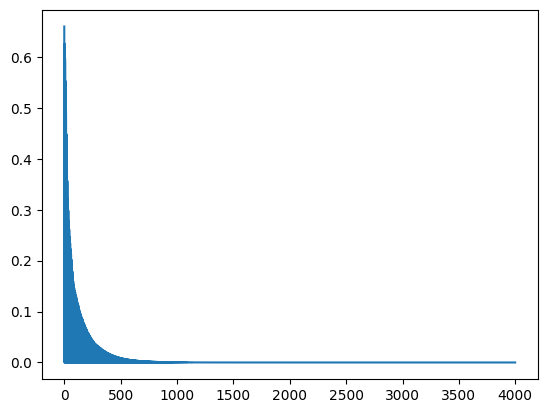

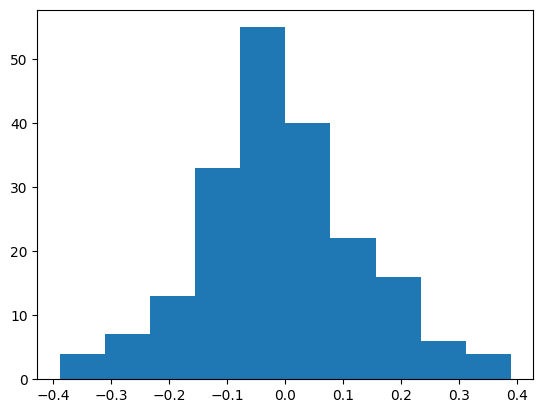

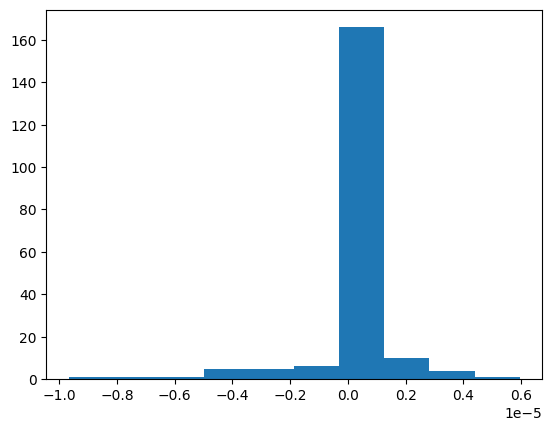

0


In [4]:
np.random.seed(100)

x = np.random.randn(2, 100) * 0.1
y = np.random.randn(100, 1) 


x = x.astype(np.float32)
y = y.astype(np.float32)

class xor_net_mini():

    def __init__(self):
        self.L1 = Tensor(x) # 2x100
        self.L2 = Tensor(y) # 100x1
        
    def forward(self, x):
        fir = x.dot(self.L1).ReLU()   # 2x1
        out = fir.dot(self.L2)  *0.3
        return out

xor_mini = xor_net_mini()
optim1 = Optim((xor_mini.L1, xor_mini.L2,)) 


X_data_mini = Tensor([[1.,0.], [1., 1.], [0., 0.], [0.,1.]])
Y_data_mini = Tensor([[1.], [0.], [0.], [1.]])

losses = []
empty_numpy  = np.array([])
empty_numpy2  = np.array([])

for i in range(1000):
    for x, y in zip(X_data_mini ,Y_data_mini):

        logits = xor_mini.forward(x)
        
       
        loss =  ((y - logits)**2)

        losses.append(loss)

        loss.backward()

        optim1.step()

        o = np.append(empty_numpy2, xor_mini.L1.grad.data.flatten())

        optim1.zero_grad(loss.ALL_PARAMS)


            
        p = np.append(empty_numpy, xor_mini.L1.data.flatten())
        
        
    if i % 100 == 0:
        print(loss)

loss_plot = [x.data for x in losses]
plt.plot(loss_plot)
plt.show()

plt.hist(p)
plt.show()

plt.hist(o)
plt.show()
print(xor_mini.L1.grad)

In [5]:
np.random.seed(1000)
x = np.random.randn(1,2) * 0.1
y = np.random.randn(1,2)
parameters  = [x, y]


params_prev = [0 for x  in parameters]
params = [x for x in parameters]
prams_grad = [x * 0.1 for x in parameters]

print(params)
print()
lr = 0.1
for i in range(2):
    for i , (parameter , prev_parameter, prameter_grad) in enumerate(zip(params, params_prev, prams_grad)):
        print(prev_parameter)
        params[i] = prev_parameter - (0.1  * prameter_grad)
        params_prev[i] =params[i]

    print(f"PARAMS  = {params}")
    print(f"PARAMS_PREV   = {params_prev}")



[array([[-0.08045,  0.03209]]), array([[-0.02548,  0.64432]])]

0
0
PARAMS  = [array([[ 0.0008 , -0.00032]]), array([[ 0.00025, -0.00644]])]
PARAMS_PREV   = [array([[ 0.0008 , -0.00032]]), array([[ 0.00025, -0.00644]])]
[[ 0.0008  -0.00032]]
[[ 0.00025 -0.00644]]
PARAMS  = [array([[ 0.00161, -0.00064]]), array([[ 0.00051, -0.01289]])]
PARAMS_PREV   = [array([[ 0.00161, -0.00064]]), array([[ 0.00051, -0.01289]])]


In [6]:
print(params_prev)

[array([[ 0.00161, -0.00064]]), array([[ 0.00051, -0.01289]])]


In [7]:
niz = [1,2,4]

for i, clan in enumerate(niz):
    clan = 0

print(niz)

[1, 2, 4]
